## Import packages

In [8]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar
from pyomo.contrib.parmest.experiment import Experiment

# Model
This example data is imported Hill chapter 3 reaction engineering Example 3.1 p.37 
"ILLUSTRATION 3.1 Use of a Differential Method to Determine a Pseudo Reaction Rate 
Expression for the Iodine-Catalyzed Bromination of m-Xylene". <br>

The model is a reaction kinetics model which follows:

$$
-\frac{dC_A}{dt} = kC_A^{\,n}
$$

## Dataset for the model

In [9]:
# Data as a dictionary
bromine_data = {
    "Time": [0.00, 2.25, 4.50, 6.33, 8.00, 10.25, 12.00, 13.50, 15.60, 17.85,
                   19.60, 27.00, 30.00, 38.00, 41.00, 45.00, 47.00, 57.00, 63.00],
    "CA": [0.3335, 0.2965, 0.2660, 0.2450, 0.2255, 0.2050, 0.1910, 0.1794, 0.1632, 
           0.1500, 0.1429, 0.1160, 0.1053, 0.0830, 0.0767, 0.0705, 0.0678, 0.0553, 0.0482]
}

## Model for ``DOE``

In [10]:
class ReactionOrder(Experiment):
   
    def __init__(self, data, CA0 = None,  theta_initial = None, nfe=20, ncp=3):
        """
        Arguments:
        data : object containing vital experimental information. dictionary, pandas dataframe
        theta_initial : initial values of the parameters theta. dtype: dict
        nfe : number of number of finite elements
        ncp : number of collocation points
        """
        self.data = data
        self.CA0 = CA0
        self.nfe = nfe  # number of finite elements
        self.ncp = ncp  # number of collocation points
        self.model = None   

        # Defining the parameter values
        if theta_initial is None:
            self.theta_initial = {
                "k" : 0.10, # rate constant (L/mol)^0.5 /min
                "n" : 1.54  # rxn order
            }
        else:
            self.theta_initial = theta_initial
        
    # End of constructor definition
    ########################################################################

    def get_labeled_model(self):
        # get_labeled_model is a mandatory method in both parmest and DOE.
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_experiment()
        return self.model

    ########################################################################
    # Create flixible model without data
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """
        
        m = self.model = pyo.ConcreteModel()

        ########################################################################
        # Define model variables
        # time
        m.t = ContinuousSet(bounds=(0, 63))  # does it matter if we set it as a tuple or as a list?
        
        # concentration of reactant, Bromine (A)
        m.CA = pyo.Var(m.t, domain = pyo.NonNegativeReals, initialize = 1e-6)

        # parameters of the model
        m.k = pyo.Var(domain = pyo.NonNegativeReals)  # rate constant
        m.n = pyo.Var(domain = pyo.NonNegativeReals)       # order of the rxn     
               
        # Differential variable, conc
        m.dCAdt = DerivativeVar(m.CA, wrt = m.t)
                
        # Expression for rate
        @m.Constraint(m.t)
        def CA_rxn_rate(m, t):
            return m.dCAdt[t] == - m.k * m.CA[t] ** m.n
        
        return m        
        # End of var and constraint definiton
        ########################################################################

    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """
        m = self.model
        
        # Fixing the unknown parameter values. Only required in DOE. 
        # parmest does not require parameters to be fixed
        m.k.fix(self.theta_initial["k"])  # fixing the rate constant
        m.n.fix(self.theta_initial["n"])  # fixing the reaction order

        # Set the initial concentration of A
        # if self.CA0 is None:
        #     m.CA[0].value = self.data["CA"][0]  # Setting the first value of CA as CA0
        # else:
        #     #m.CA[0].value = self.CA0
        
        m.CA[0].fix(self.data["CA"][0])

        # Add lower bound of CA[0]    
        m.CA[0].setlb(0.01)
        # Add upper bound of CA[0]
        m.CA[0].setub(0.5)  # let's set the upper bound to 10M

        # Control points again 
        m.t_control = self.data["Time"]

        # update model time ``t`` with time range and control time points
        # t_range??????????????
        # m.t.update([0, 63])
        m.t.update(m.t_control)
        

        # Discretizing the model
        discr = pyo.TransformationFactory("dae.collocation")
        discr.apply_to(m, nfe = self.nfe, ncp = self.ncp, wrt = m.t)
        # or nfe = len(self.data.Time) - 1 ???????????????????????

        # solver = pyo.SolverFactory("ipopt")
        # solver.solve(m, tee=True)
        
        return m
        # End of model finalization
        ####################################################

    ####################################################
    # Labeling the experiment
    def label_experiment(self):
        """
        The model is updated with outputs, inputs, errors and unknown parameters
        This makes the model labeled with full experiment
        """
        m = self.model

        # Set measurement labels
        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # Add CA to experiment outputs
        m.experiment_outputs.update((m.CA[t], None) for t in m.t_control)
        # We don't need the second element of the tuple. We don't care about that element in DOE

        # Add measurement error. Let's assume an constant error of 3% CA. 
        # My next plan is to create a random error between 3% and 10% and see the result
        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.measurement_error.update((m.CA[t], 0.03) for t in m.t_control)

        # Identify design variables
        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # Addd experimental input label for initial concentration
        m.experiment_inputs[m.CA[m.t.first()]] = None

        # Add unknown parameter labels
        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.k, m.n])

        # End of model labeling
        
        return m
        ####################################################   

## DOE Example

In [11]:
from pyomo.common.dependencies import numpy as np
from pyomo.contrib.doe import DesignOfExperiments
import pyomo.environ as pyo

FIM of the experiment:
 [[ 128.94994164 -320.3803385 ]
 [-320.3803385   819.61704152]]

OPTIMAL EXPERIMENT VALUES: 
	Initial Concentration:  0.50


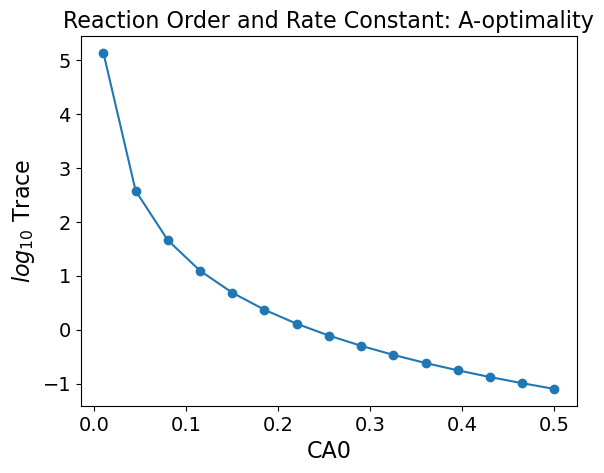

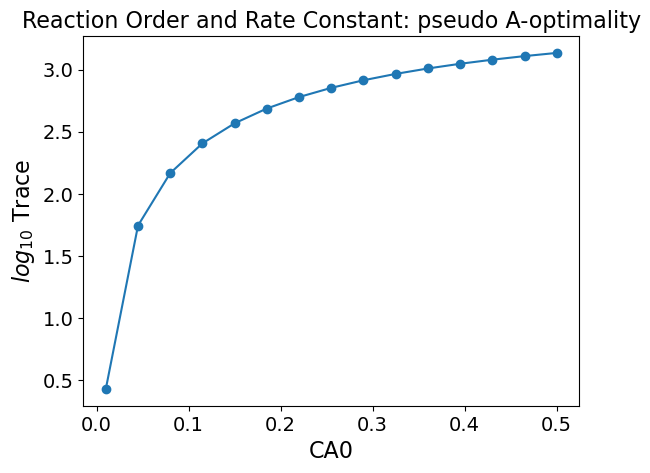

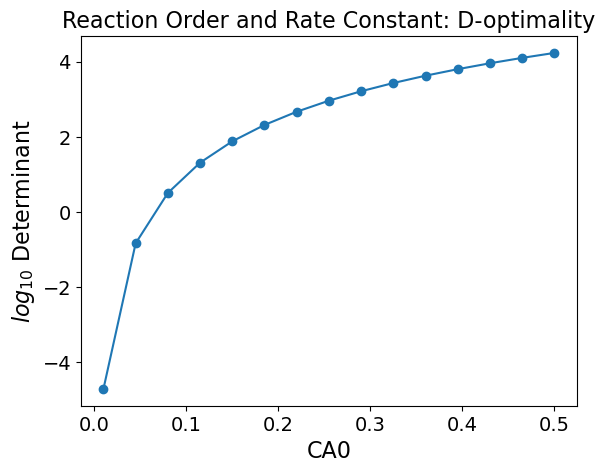

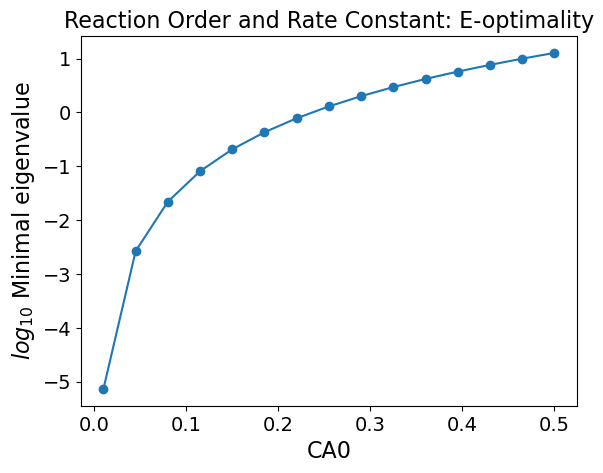

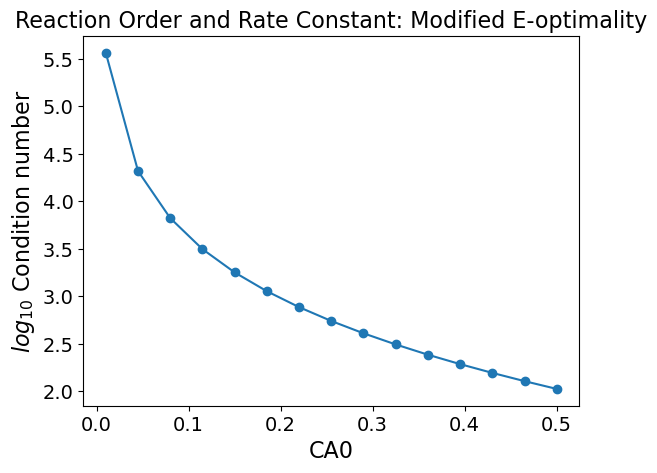

In [12]:
def run_reactor_doe():
    # Create a ReactorOrder object
    experiment = ReactionOrder(data = bromine_data, nfe = 30, ncp = 3)

    # Use the determinant (D-optimality) with scaled sensitivity matrix
    objective_option = "determinant"
    scale_nominal_param_value = True

    # # Create the DesignOfExperiment object
    # doe_obj = DesignOfExperiments(
    #     experiment,
    #     objective_option= objective_option,
    #     scale_nominal_param_value=scale_nominal_param_value,
    # )

    solver = pyo.SolverFactory("ipopt")
    solver.options["linear_solver"] = "MA57"

    # Create the DesignOfExperiments object
    doe_obj = DesignOfExperiments(
        experiment,
        objective_option= objective_option,
        scale_nominal_param_value=scale_nominal_param_value,
        solver=solver,
    )

    # I haven't defined the other parameters, because the defaults values are used in the doe example.
    FIM = doe_obj.compute_FIM()
    print("FIM of the experiment:\n", FIM)

    # Make design ranges to compute the full factorial design
    design_ranges = {"CA[0]" : [0.01, 0.5, 15]}  # this `key` needs to have the same name as the design variable we defined in our `class`

    # Compute the full factorial design  with the sequential FIM calculation
    doe_obj.compute_FIM_full_factorial(design_ranges = design_ranges, method = "sequential")

    # plot the results
    doe_obj.draw_factorial_figure(
        sensitivity_design_variables= ["CA[0]"],
        fixed_design_variables= {},  # What to put as `fixed_design_variables` for single design variable model.
        title_text = "Reaction Order and Rate Constant",
        xlabel_text= "CA0",  # this name needs to have the same name as the design variable we defined in our `class`
        log_scale= False,
        figure_file_name= "Reaction_order_example"
    )

    # End of Sensitivity Analysis
    #################################

    #################################
    # Begin optimal design of experiments
    doe_obj_opt = DesignOfExperiments(
        experiment,
        objective_option=objective_option,
        scale_nominal_param_value=scale_nominal_param_value,
        solver=solver,
        prior_FIM= FIM  # Use the FIM from before as prior information
    )
    doe_obj_opt.run_doe()

    # Print out a results summary
    print("\nOPTIMAL EXPERIMENT VALUES: ")
    print(
        f"\tInitial Concentration: {doe_obj_opt.results['Experiment Design'][0]: 0.2f}"
    )

run_reactor_doe()